### mini-ensemble of CESM2-4p2z historical + ssp370

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

#import cftime
import matplotlib.colors as colors
import utils

###  specify desired variables

In [3]:
variables = ['photoC_TOT_zint_100m','POC_FLUX_100m','IFRAC']

In [4]:
def preprocess(ds):
    tb = ds.time_bound
    ds=ds.isel(z_t=slice(0,10)).mean(dim='z_t')
    ds['time_bound'] = tb
    return ds

### Grab the first ensemble member (002) - this one goes from 1850 to 2014 (hist) and 2015 to 2100 (ssp)

#### Get historical part

In [5]:
case = 'b.e21p4.B1850.TL319_g17.4p2z.002' #there's a mistake in the naming convention
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [6]:
ds = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True) #, preprocess=preprocess)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds = xr.merge([ds,ds_tmp],combine_attrs='override')

starting on  photoC_TOT_zint_100m
starting on  POC_FLUX_100m
starting on  IFRAC


### fix the time dimension

In [7]:
ds['time'] = ds.time_bound.compute().mean(dim="d2")

In [9]:
ds.time #380 years long control

<xarray.DataArray 'time' (time: 4560)>
array([cftime.DatetimeNoLeap(121, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(121, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(121, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(500, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0121-01-16 12:00:00 ... 0500-12-16 12:00:00

### Now spin up a cluster and do some analysis

In [10]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [11]:
cluster, client = get_ClusterClient()
cluster.scale(18) 
client

Client Scheduler: tcp://128.117.208.83:36109 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/32911/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### get coords and make a ones array for masking

In [12]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m = area * 1.e-4
area_km = area * 1.e-10
lons_norm = utils.normal_lons(lons)

In [13]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [14]:
ds

<xarray.Dataset>
Dimensions:               (d2: 2, nlat: 384, nlon: 320, time: 4560, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                  (time) object 0121-01-16 12:00:00 ... 0500-12-16 12...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound            (time, d2) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    photoC_TOT_zint_100m  (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    POC_FLUX_100m         (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    IFRAC                 (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>

### Create a SIZ mask using seasonal average JJA (I'll make DJF and SON too, just in case)

In [18]:
ds_djf = xr.Dataset()
ds_jja = xr.Dataset() # for calculating SIZ mask, whether or not the wintertime ifrac makes a big difference for the following growing season
ds_son = xr.Dataset()

sp = 8 # sept index , rearing period (rp)
i = 5 # june index for jja averages
s = 11 #december index for djf averages, summer (s)

for year in np.arange(0,380,1):
        
        #print(year,sp,s,i)
    
        
        ### JJA
        jja = ds.isel(time=slice(i,i+3)).mean(dim='time')

        ds_jja = xr.concat([ds_jja,jja],dim='time')

        i = i + 12
        
                
        ### SON
        son = ds.isel(time=slice(sp,sp+3)).mean(dim='time')

        ds_son = xr.concat([ds_son,son],dim='time')

        sp = sp + 12
        
                        
        ### DJF
        djf = ds.isel(time=slice(s,s+3)).mean(dim='time')

        ds_djf = xr.concat([ds_djf,djf],dim='time')

        s = s + 12


ds_djf['time'] = np.arange(1,381,1)
ds_son['time'] = np.arange(1,381,1)
ds_jja['time'] = np.arange(1,381,1)

### Let's make some timeseries figure, just use SIZ as as example mask

#### define Antarctic SIZ as JJA ifrac > 0.85 over the mean over the first 10 years of the run

In [19]:
SIZ_mask = ones.where(ds_jja.IFRAC.isel(time=slice(0,100)).mean(dim='time') > 0.85).where(lats<0)

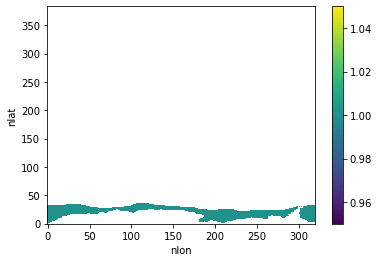

In [20]:
SIZ_mask.plot()

In [21]:
ts_siz_djf = xr.Dataset()
ts_siz_son = xr.Dataset()
ts_siz_jja = xr.Dataset()


for var in variables:
    
    print(var)

    masked_area = area.where(SIZ_mask==1)

    ### DJF
    masked_var = ds_djf[var].where(SIZ_mask==1)
    ts_siz_djf[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    ### SON
    masked_var = ds_son[var].where(SIZ_mask==1)
    ts_siz_son[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    ### SON
    masked_var = ds_jja[var].where(SIZ_mask==1)
    ts_siz_jja[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

photoC_TOT_zint_100m
POC_FLUX_100m
IFRAC


In [23]:
ts_siz_djf['time'] = np.arange(1,381,1)
ts_siz_son['time'] = np.arange(1,381,1)
ts_siz_jja['time'] = np.arange(1,381,1)

In [31]:
ts_siz_djf.isel(time=slice(0,379))

<xarray.Dataset>
Dimensions:               (time: 379)
Coordinates:
  * time                  (time) int64 1 2 3 4 5 6 7 ... 374 375 376 377 378 379
Data variables:
    photoC_TOT_zint_100m  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    POC_FLUX_100m         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    IFRAC                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [32]:
ts_siz_djf = ts_siz_djf.isel(time=slice(0,379))
ts_siz_son = ts_siz_son.isel(time=slice(0,379))
ts_siz_jja = ts_siz_jja.isel(time=slice(0,379))


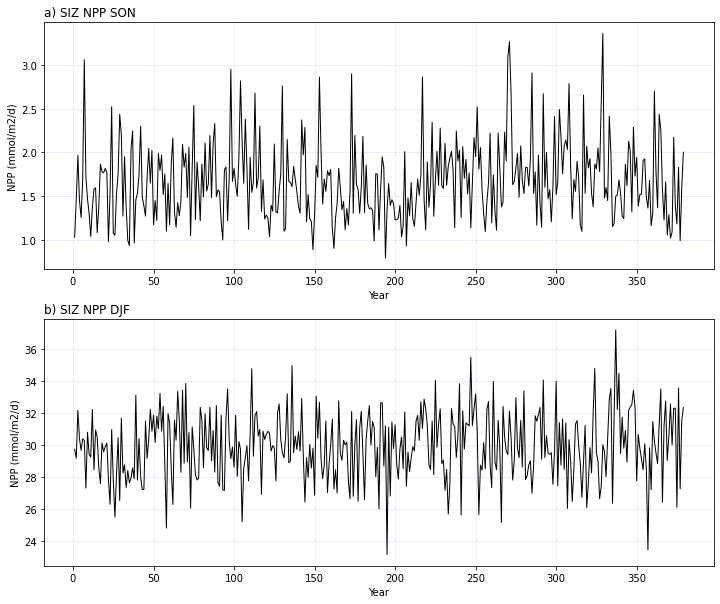

In [33]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1)
ax.set_title('a) SIZ NPP SON', loc='left')

ax.plot(ts_siz_son['time'], ts_siz_son['photoC_TOT_zint_100m']*86400.*0.01,linewidth=1,color='black')
        
ax.set(ylabel='NPP (mmol/m2/d)',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
#############################3
ax = fig.add_subplot(2,1,2)
ax.set_title('b) SIZ NPP DJF', loc='left')

ax.plot(ts_siz_djf['time'], ts_siz_djf['photoC_TOT_zint_100m']*86400.*0.01,linewidth=1,color='black')
        
ax.set(ylabel='NPP (mmol/m2/d)',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');

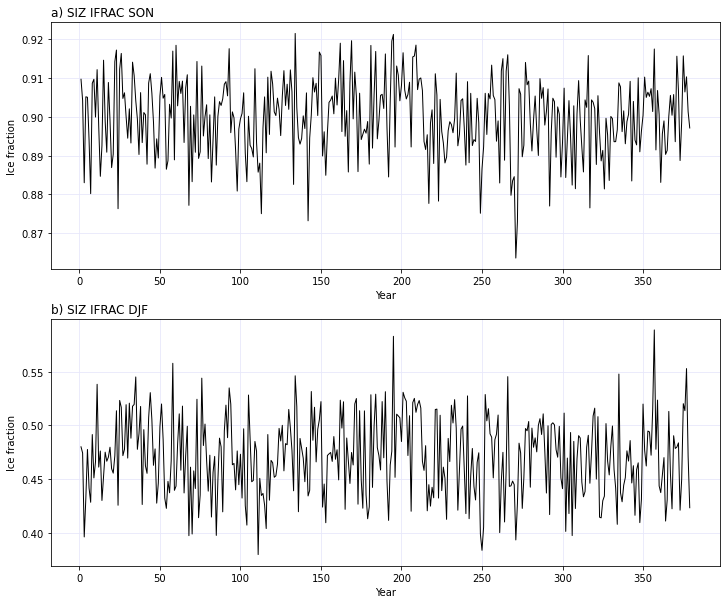

In [34]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1)
ax.set_title('a) SIZ IFRAC SON', loc='left')

ax.plot(ts_siz_son['time'], ts_siz_son['IFRAC'],linewidth=1,color='black')
        
ax.set(ylabel='Ice fraction',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
################
ax = fig.add_subplot(2,1,2)
ax.set_title('b) SIZ IFRAC DJF', loc='left')

ax.plot(ts_siz_djf['time'], ts_siz_djf['IFRAC'],linewidth=1,color='black')
        
ax.set(ylabel='Ice fraction',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');